# Histograms
This notebook demonstrates simple use of histograms in wn.

### Set up libraries and load exemplar dataset

In [1]:
# load libraries
import os
import opendp.whitenoise.core as wn
import numpy as np
import math
import statistics

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (1000,)
Names of variables:   ('age', 'sex', 'educ', 'race', 'income', 'married')


### Creating DP Releases of Histograms

The default method for generating a histogram in WhiteNoise is by releasing counts of each bin or category using the geometric mechanism.  The geometric mechanism only returns integer values for any query, so resists some vulnerabilities of DP releases from floating point approximations.  It is also possible, however, to generate histograms from the more typical Laplace mechanism.  We show both approaches below.

Here we generate histograms on three types of variables:
* A continuous variable, here `income`, where the set of numbers have to be divided into bins,
* A boolean or dichotomous variable, here `sex`, that can only take on two values,
* A categorical variable, here `education`, where there are distinct categories enumerated as strings.

Note the education variable is coded in the data on a scale from 1 to 16, but we're leaving the coded values as strings throughout this notebook.

In [2]:
income_edges = list(range(0, 100000, 10000))
education_categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]


with wn.Analysis() as analysis:
    data = wn.Dataset(path = data_path, column_names = var_names)
        
    income_histogram = wn.dp_histogram(
            wn.cast(data['income'], type='int', lower=0, upper=100),
            edges = income_edges,
            upper = 1000,
            null_value = 150,
            privacy_usage = {'epsilon': 0.5}
        )

    income_prep = wn.histogram(wn.cast(data['income'], type='int', lower=0, upper=100),
                                     edges=income_edges, null_value =-1)
    income_histogram2 = wn.laplace_mechanism(income_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    
    sex_histogram = wn.dp_histogram(
            wn.cast(data['sex'], type='bool', true_label="0"),
            upper = 1000,
            privacy_usage = {'epsilon': 0.5}
        )
    
    sex_prep = wn.histogram(wn.cast(data['sex'], type='bool', true_label="0"), null_value = True)
    sex_histogram2 = wn.laplace_mechanism(sex_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    
    education_histogram = wn.dp_histogram(
            data['educ'],
            categories = education_categories,
            null_value = "-1",
            privacy_usage = {'epsilon': 0.5}
        )

    education_prep = wn.histogram(data['educ'],
            categories = education_categories, null_value = "-1")
    education_histogram2 = wn.laplace_mechanism(education_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    

analysis.release()

print("Income histogram Geometric DP release:   " + str(income_histogram.value))
print("Income histogram Laplace DP release:     " + str(income_histogram2.value))

print("Sex histogram Geometric DP release:      " + str(sex_histogram.value))
print("Sex histogram Laplace DP release:        " + str(sex_histogram2.value))

print("Education histogram Geometric DP release:" + str(education_histogram.value))
print("Education histogram Laplace DP release:  " + str(education_histogram2.value))

Income histogram Geometric DP release:   [367 264  37  63  59  34  51 -11  55  75]
Income histogram Laplace DP release:     [324.45092757 178.82037798 118.28873947 103.66583386  61.62697456
  43.630394    38.52333766  12.12935521   9.14201665  77.41283735]
Sex histogram Geometric DP release:      [537 503]
Sex histogram Laplace DP release:        [488.36041898 518.32802591]
Education histogram Geometric DP release:[ 66  18  41  46  25 -11  46  75 192  -2 177  51 152  41  24   7   2]
Education histogram Laplace DP release:  [ 32.91981094  12.51180203  33.83514271  19.62786034   7.69518197
  21.29380177  29.41669808  44.18458864 195.38747852  62.98036544
 176.18085411  67.66628731 181.03849119  57.06296938  20.27422824
  12.48152548  -6.37443803]


We can see most obviously that the releases from the Geometric mechanism are integer counts, while the Laplace releases are floating point numbers.

Below, we will quickly create histograms of the actual private data, for a point of comparison to our differentially private releases:

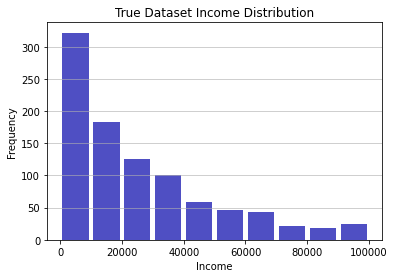

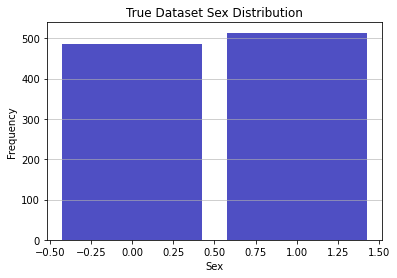

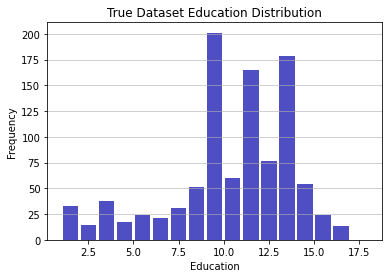

In [3]:
import matplotlib.pyplot as plt

data = np.genfromtxt(data_path, delimiter=',', names=True)
income = list(data[:]['income'])
sex = list(data[:]['sex'])
education = list(data[:]['educ'])

# An "interface" to matplotlib.axes.Axes.hist() method
n_income, bins, patches = plt.hist(income, bins=list(range(0,110000,10000)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('True Dataset Income Distribution')
plt.show()

n_sex, bins, patches = plt.hist(sex, bins=[-0.5,0.5,1.5], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('True Dataset Sex Distribution')
plt.show()

n_educ, bins, patches = plt.hist(education, bins=list(range(1,19,1)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('True Dataset Education Distribution')
plt.show()

Below we can see the differentially private releases of these variables in shades of red, against the "true" private counts in green.

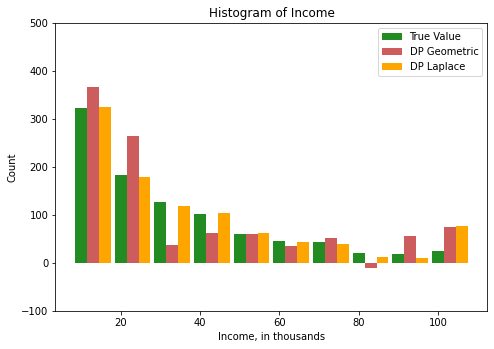

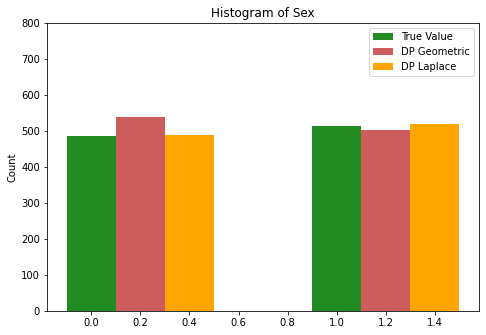

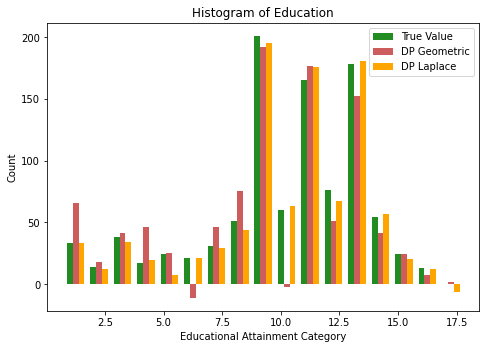

In [4]:
import matplotlib.pyplot as plt

colorseq = ["forestgreen", "indianred", "orange", "orangered", "orchid"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim([-100,500])
#inccat = ["10k","20k","30k","40k","50k","60k","70k","80k","90k","100k"]
inccat = [10,20,30,40,50,60,70,80,90,100]
width=3
inccat_left = [x + width for x in inccat]
inccat_right = [x + 2*width for x in inccat]
ax.bar(inccat, n_income, width=width, color=colorseq[0], label='True Value')
ax.bar(inccat_left, income_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(inccat_right, income_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Income')
plt.xlabel('Income, in thousands')
plt.ylabel('Count')
plt.show()



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim([0,800])
sexcat = [0,1]
width = 0.2
sexcat_left = [x + width for x in sexcat]
sexcat_right = [x + 2*width for x in sexcat]
ax.bar(sexcat, n_sex, width=width, color=colorseq[0], label='True Value')
ax.bar(sexcat_left, sex_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(sexcat_right, sex_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Sex')
plt.ylabel('Count')
plt.show()


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
edcat = list(range(1,18))
width = 0.25
edcat_left = [x + width for x in edcat]
edcat_right = [x + 2*width for x in edcat]
ax.bar(edcat, n_educ, width=width, color=colorseq[0], label='True Value')
ax.bar(edcat_left, education_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(edcat_right, education_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Education')
plt.xlabel('Educational Attainment Category')
plt.ylabel('Count')
plt.show()
